# Разработка A/B-тестирования рекомендательной системы

Рассмотрим компанию, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В нашем приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Необходимо рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

Даны таблицы:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-11 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
Рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

### 1. Работа с историческими данными (EDA)

На первом этапе поработайте с историческими данными приложения:

In [ ]:
# импортируем pandas, matplotlib, scipy
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


In [ ]:
# выгружаем данные
session_history = pd.read_csv('path/sessions_project_history.csv')

session_history.head()

#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитаем количество уникальных сессий `session_id`.

- Выведем на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий.

- Изучим таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.



In [2]:
# группируем данные и получаем максимальное число сессий
users_sessions = session_history.groupby('user_id')['session_id'].count()
max_count_session = users_sessions.max()

# находим user_id пользователя с макс. кол-вом сессией
user_id_with_max_count_session = users_sessions[users_sessions == max_count_session]
user_id_with_max_count_session = user_id_with_max_count_session.index[0]

# получаем информацию по этому пользователю
df_by_user_id_with_max_session = session_history[session_history['user_id'] == user_id_with_max_count_session]
df_by_user_id_with_max_session

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируем, как менялось число регистраций в приложении за время его существования.

- Агрегируем исторические данные и рассчитаем число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты будем считать, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Построим линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням.

- Построим отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

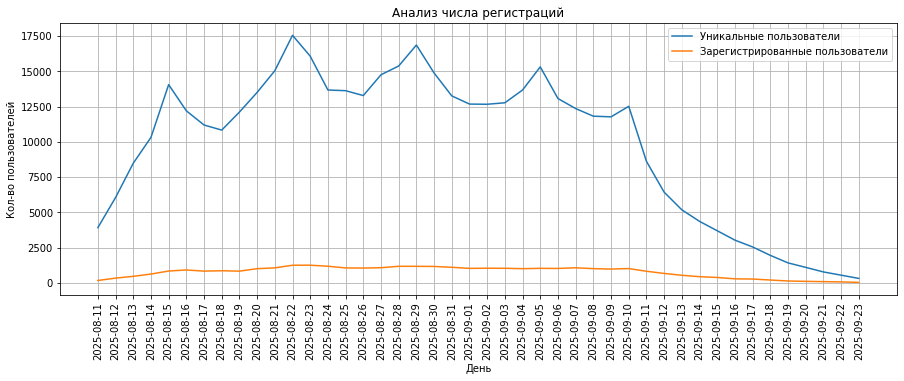

In [3]:
# находим общее кол-во уникальных пользователей
uniq_users = session_history.groupby('session_date')['user_id'].count()

# находим зарегистрированных пользователей
regisrt_users = session_history[session_history['registration_flag'] == 1]
regisrt_users = regisrt_users.groupby('session_date')['user_id'].count()

plt.figure(figsize=(15, 5))

# первая линия для уникальных пользователей
plt.plot(uniq_users, label='Уникальные пользователи')

# вторая линия для зарегистрированных пользователей
plt.plot(regisrt_users, label='Зарегистрированные пользователи')

# оформление графика
plt.title('Анализ числа регистраций')
plt.xlabel('День')     
plt.ylabel('Кол-во пользователей')
plt.legend() 
plt.xticks(rotation=90)
plt.grid(True) 

# Отображение графика
plt.show()

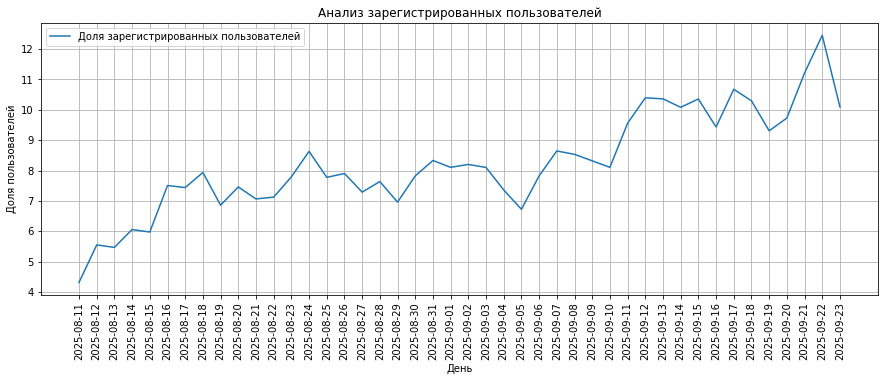

In [4]:
# находим долю зарегистрированных от общего числа пользователей
share_registr_users = regisrt_users / uniq_users * 100

plt.figure(figsize=(15, 5))

# строим график
plt.plot(share_registr_users, label='Доля зарегистрированных пользователей')

# оформление графика
plt.title('Анализ зарегистрированных пользователей')
plt.xlabel('День')     
plt.ylabel('Доля пользователей')
plt.legend() 
plt.xticks(rotation=90)
plt.grid(True) 

# Отображение графика
plt.show()

#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы, что он зарегистрируется и оплатит подписку.

- Найдем количество сессий для каждого значения количества просмотренных страниц. Например: одну страницу просмотрели в 29 160 сессиях, две страницы — в 105 536 сессиях и так далее.

- Построим столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

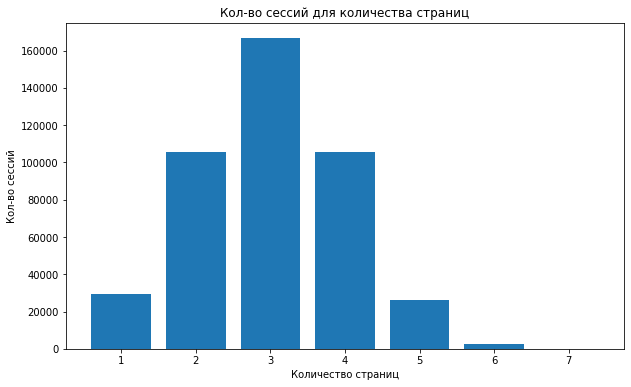

In [5]:
# находим кол-во сессий для кол-ва просмотренных страниц
page_count = session_history.groupby('page_counter')['session_id'].count()
pages = page_count.index
sessions = page_count.values

# строим столбчатую диаграмму
plt.figure(figsize=(10, 6))

plt.bar(pages, sessions)

plt.title('Кол-во сессий для количества страниц')
plt.xlabel('Количество страниц')
plt.ylabel('Кол-во сессий')

plt.show()

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Будем считать, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Построим график со средним значением доли успешных сессий от всех сессий по дням за весь период наблюдения.

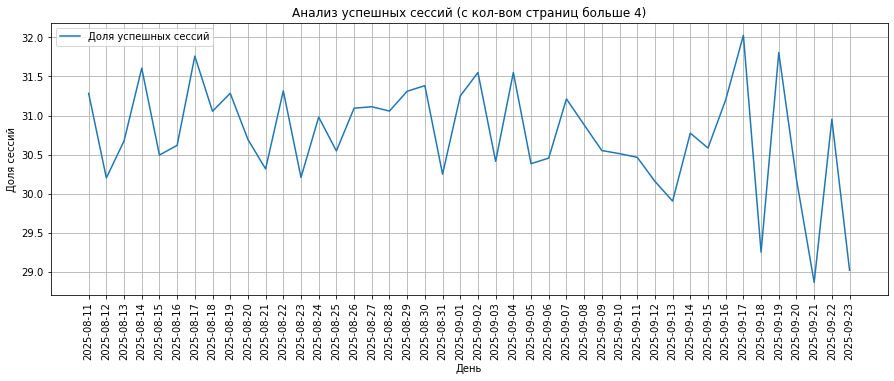

In [6]:
# cоздаём новый столбец и изначально заполняем его нулями
session_history['good_session'] = 0

# меняем значения на 1 там, где page_counter больше 4
session_history.loc[session_history['page_counter'] >= 4, 'good_session'] = 1

# находим общее кол-во сессий за день
grouped_session_all = session_history.groupby('session_date')['session_id'].count()

# находим "успешные" сессии
good_session = session_history[session_history['good_session'] == 1]
good_session = good_session.groupby('session_date')['session_id'].count()

# находим долю "успешных" сессий от общего числа
share_good_sessiob = good_session / grouped_session_all * 100

plt.figure(figsize=(15, 5))

# строим график
plt.plot(share_good_sessiob, label='Доля успешных сессий')

# оформление графика
plt.title('Анализ успешных сессий (с кол-вом страниц больше 4)')
plt.xlabel('День')     
plt.ylabel('Доля сессий')
plt.legend() 
plt.xticks(rotation=90)
plt.grid(True) 

# Отображение графика
plt.show()

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Сформулировать нулевую и альтернативную гипотезы

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика рассчитать необходимую длительность проведения теста.

#### 2.1 Формулировка нулевой и альтернативной гипотез

Перед тем как проводить А/B-тест, необходимо сформулировать нулевую и альтернативную гипотезы. В качестве целевой метрики будем использовать количество успешных сессий, то есть тех, где пользователь посетил четыре и более страницы.

Сформулируйте нулевую и альтернативную гипотезы:

`🔖 H0: Кол-во "успешных" сессий не увеличится`

`🔖 H1: Кол-во "успешных" сессий увеличится`



#### 2.2. Расчёт размера выборки
Для расчета размера выборки установим в коде ниже следующие параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%. Обратите внимание, что здесь нужно указать десятичную дробь, а не процент.

При расчёте размера выборки будем использовать метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

In [7]:
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 0.8  # Мощность теста
p = 0.3 # Базовый уровень доли
mde = 0.03 * p  # Минимальный детектируемый эффект
effect_size = proportion_effectsize(p, p + mde)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 41040


#### 2.3. Расчёт длительности A/B-теста

Используя данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения, рассчитаем длительность теста, разделив одно на другое.

- Рассчитаем среднее количество уникальных пользователей приложения в день.

- Определим длительность теста исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения.

In [8]:
from math import ceil

# Среднее количество пользователей приложения в день по историческим данным
count_users = session_history.groupby('session_date')['user_id'].nunique()
avg_daily_users = round(count_users.mean())

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(int(sample_size * 2) / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907 пользователей в день составит 9 дней


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Рассчитаем количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитаем и выведем на экран процентную разницу в количестве пользователей в группах A и B.

Для расчёта процентной разницы воспользуемся формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

In [ ]:
# считываем данные
sessions_test_part = pd.read_csv('path/sessions_project_test_part.csv')
sessions_test_part.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


In [10]:
# так как данные представлены только за один день, можно использовать группировку только по группе 
count_days = sessions_test_part.groupby('test_group')['user_id'].nunique()

# расчитаем процентную разницу
a = count_days.values[0]
b = count_days.values[1]
p = round(100 * ((abs(a - b)) / a), 3)

print(f'В группе A {count_days.values[0]} участников, в группе В {count_days.values[1]} участников. Разница в группах составляет {p}%')

В группе A 1477 участников, в группе В 1466 участников. Разница в группах составляет 0.745%


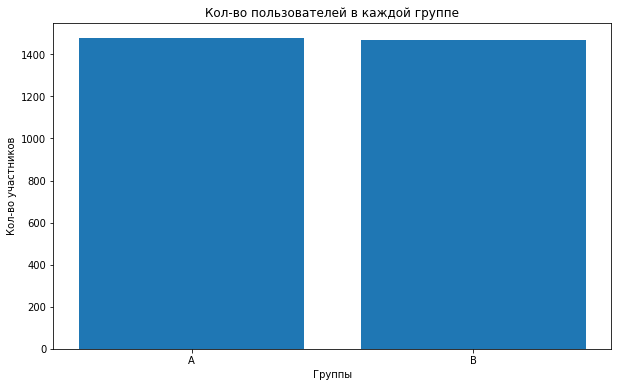

In [11]:
# строим столбчатую диаграмму
plt.figure(figsize=(10, 6))

plt.bar(count_days.index, count_days.values)

plt.title('Кол-во пользователей в каждой группе')
plt.xlabel('Группы')
plt.ylabel('Кол-во участников')

plt.show()

#### 3.2. Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах, полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

- Рассчитаем количество пользователей, которые встречаются одновременно в группах A и B, или убедимся, что таких нет.

In [12]:
# выделим участников теста в две группы
group_a = sessions_test_part[sessions_test_part['test_group'] == 'A']
group_b = sessions_test_part[sessions_test_part['test_group'] == 'B']

# проверяем совпадения
merged_group_df = pd.merge(group_a, group_b, how='inner', on=list(group_a.columns))

# проверяем наличие совпадающих строк
if merged_group_df.empty:
    print("Пользователей, которые одновременно встречаются в группах А и В, нет!")
else:
    print("Есть совпадающие пользователи:", merged_df)

Пользователей, которые одновременно встречаются в группах А и В, нет!


#### 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройств и регионам.

Построим две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.


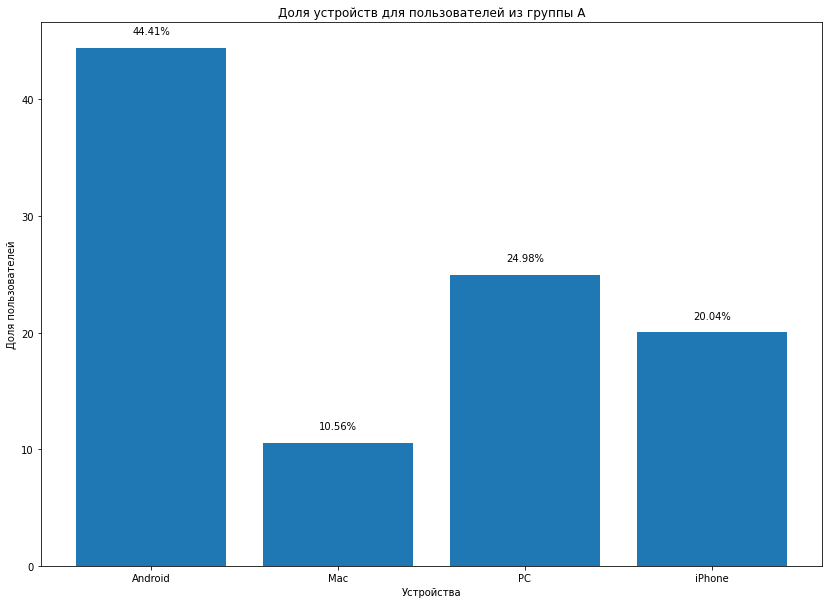

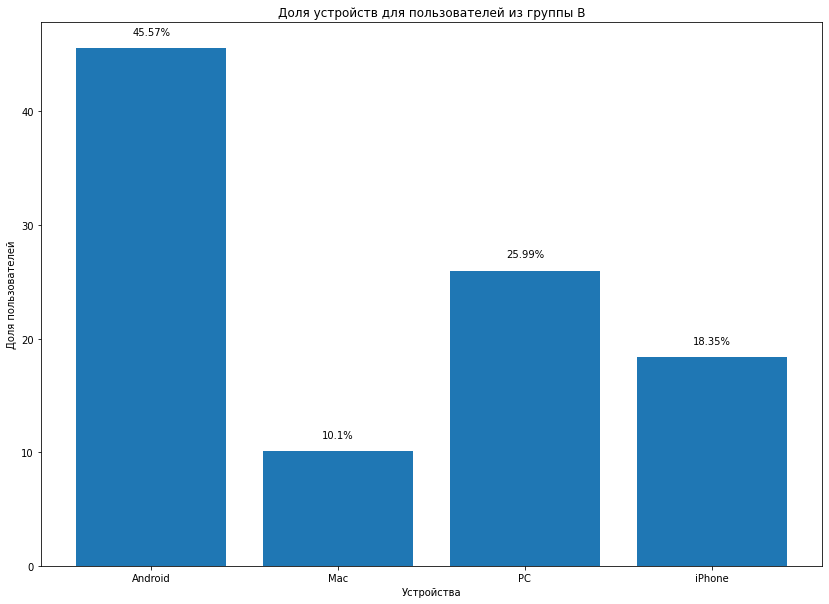

In [13]:
count_a = group_a['user_id'].nunique()
count_b = group_b['user_id'].nunique()

device_a = round(group_a.groupby('device')['user_id'].nunique() / count_a * 100, 2)
device_b = round(group_b.groupby('device')['user_id'].nunique() / count_b * 100, 2)

# строим первую диаграмму
plt.figure(figsize=(14, 10))
plt.bar(device_a.index, device_a.values)

for i, v in enumerate(device_a.values):
    plt.text(i, v + 1, f'{round(v, 2)}%', ha='center', va='bottom', fontsize=10)

plt.title('Доля устройств для пользователей из группы A')
plt.xlabel('Устройства')
plt.ylabel('Доля пользователей')

plt.show()

# строим вторую диаграмму
plt.figure(figsize=(14, 10))
plt.bar(device_b.index, device_b.values)

for i, v in enumerate(device_b.values):
    plt.text(i, v + 1, f'{round(v, 2)}%', ha='center', va='bottom', fontsize=10)

plt.title('Доля устройств для пользователей из группы В')
plt.xlabel('Устройства')
plt.ylabel('Доля пользователей')

plt.show()

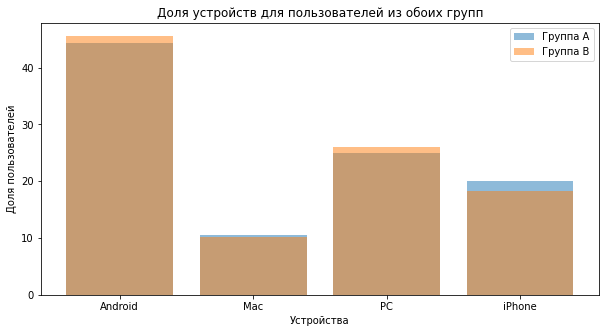

In [14]:
# для наглядности наложим диаграммы друг на друга, чтобы увидеть разницу распределения
plt.figure(figsize=(10, 5))

plt.bar(device_a.index, device_a.values, alpha=0.5, label='Группа А')
plt.bar(device_b.index, device_b.values, alpha=0.5, label='Группа В')

plt.title('Доля устройств для пользователей из обоих групп')
plt.xlabel('Устройства')
plt.ylabel('Доля пользователей')
plt.legend() 

plt.show()

#### 3.4. Равномерность распределения пользователей по регионам
Теперь убедимся, что пользователи равномерно распределены по регионам.

Построим две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.


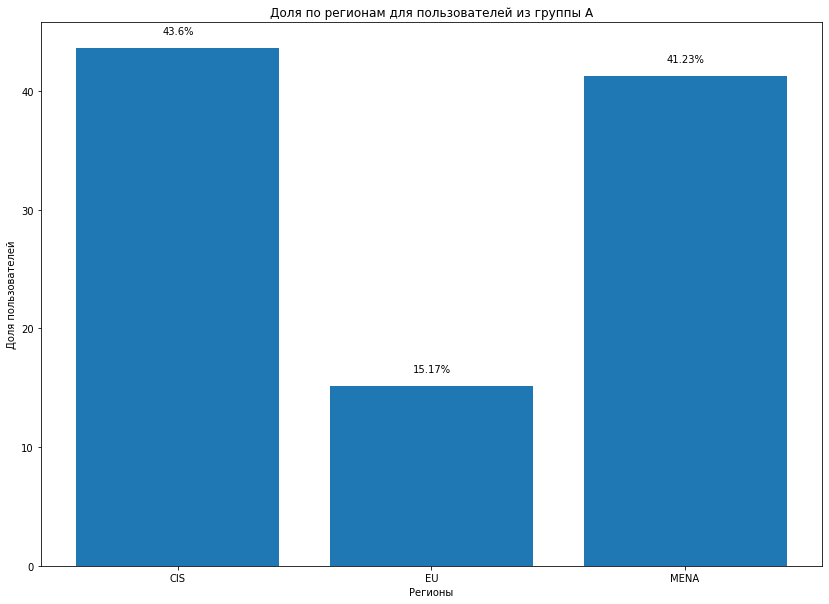

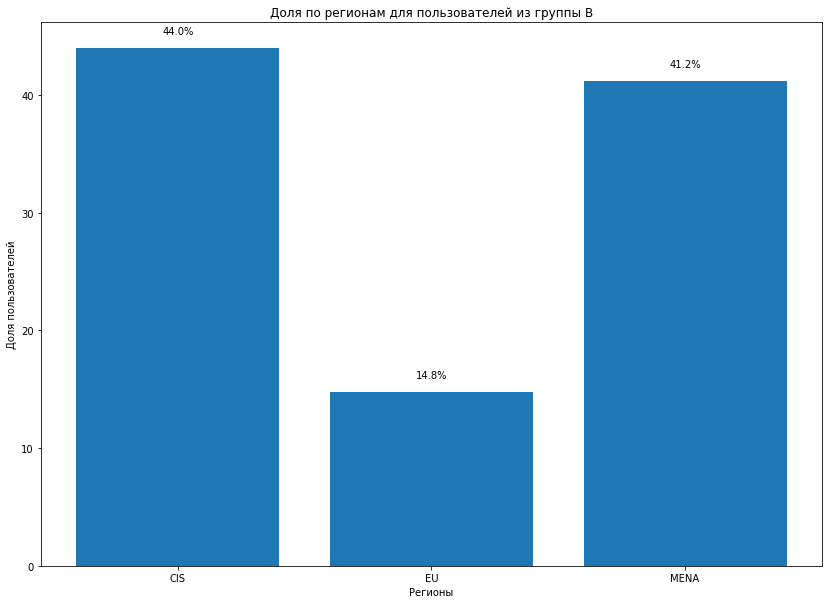

In [15]:
region_a = round(group_a.groupby('region')['user_id'].nunique() / count_a * 100, 2)
region_b = round(group_b.groupby('region')['user_id'].nunique() / count_b * 100, 2)

# строим первую диаграмму
plt.figure(figsize=(14, 10))
plt.bar(region_a.index, region_a.values)

for i, v in enumerate(region_a.values):
    plt.text(i, v + 1, f'{round(v, 2)}%', ha='center', va='bottom', fontsize=10)

plt.title('Доля по регионам для пользователей из группы A')
plt.xlabel('Регионы')
plt.ylabel('Доля пользователей')

plt.show()

# строим вторую диаграмму
plt.figure(figsize=(14, 10))
plt.bar(region_b.index, region_b.values)

for i, v in enumerate(region_b.values):
    plt.text(i, v + 1, f'{round(v, 2)}%', ha='center', va='bottom', fontsize=10)

plt.title('Доля по регионам для пользователей из группы В')
plt.xlabel('Регионы')
plt.ylabel('Доля пользователей')

plt.show()

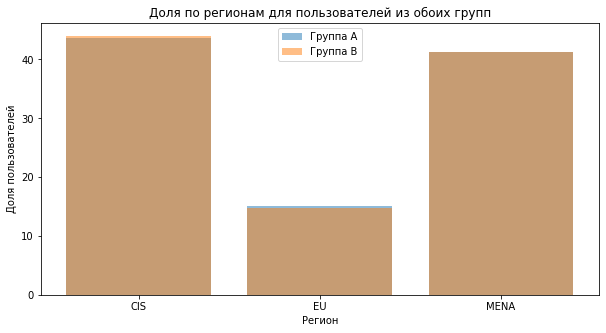

In [16]:
# для наглядности наложим диаграммы друг на друга, чтобы увидеть разницу распределения
plt.figure(figsize=(10, 5))

plt.bar(region_a.index, region_a.values, alpha=0.5, label='Группа А')
plt.bar(region_b.index, region_b.values, alpha=0.5, label='Группа В')

plt.title('Доля по регионам для пользователей из обоих групп')
plt.xlabel('Регион')
plt.ylabel('Доля пользователей')
plt.legend() 

plt.show()

#### 3.5. Вывод после проверки A/B-теста

- В группе A 1477 участников, в группе В 1466 участников. Разница в группах составляет 0.745% и является минимальной, из чего мы делаем вывод, что значительных различий в количестве пользователей в группах не обнаружено. 
- Выборки являются независимыми, так как мы не нашли пользователей, которые встречаются и в тестовой группе и в контрольной. 
- Мы рассмотрели распределение пользователей тестовой и контрольной группы по категориальным переменным: устройствам и регионам. Разница в распределении по устройствам и регионам не превышает 2-х%, из чего мы можем сделать вывод, что в выборках сохраняется равномерное распределение пользователей. 

Из этого можно сделать вывод, что мы корректно проводим А/В-тест, никаких нарушений не наблюдается!

### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у вас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

In [ ]:
# считываем данные
sessions_test = pd.read_csv('path/sessions_project_test.csv')
sessions_test.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B


In [18]:
# cоздаём новый столбец и изначально заполняем его нулями
sessions_test['good_session'] = 0

# меняем значения на 1 там, где page_counter больше 4
sessions_test.loc[sessions_test['page_counter'] >= 4, 'good_session'] = 1

sessions_test.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0


#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и мы будете сравнивать две сопоставимые группы.

- Рассчитаем количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверим, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимыми. 

- H₀ (нулевая гипотеза) — количество уникальных дневных сессий `не различается` между тестовой и контрольной группами.
- H₁ (альтернативная гипотеза) — количество уникальных дневных сессий `различается` между тестовой и контрольной группами.

In [19]:
group_a = sessions_test[sessions_test['test_group'] == 'A']
group_b = sessions_test[sessions_test['test_group'] == 'B']

count_session_a = group_a.groupby('session_date')['session_id'].count()
count_session_b = group_b.groupby('session_date')['session_id'].count()

statistic, p_value = st.ttest_ind(count_session_a, count_session_b)

print(f'p_value = {p_value}')
if p_value < 0.05:
    print('Среднее двух выборок различается!')
else:
    print('Количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимыми!')

p_value = 0.938219304859116
Количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимыми!


#### 4.3. Сравнение доли успешных сессий

Когда мы убедились, что количество сессий в обеих выборках не различалось, можно переходить к анализу ключевой метрики — доли успешных сессий.


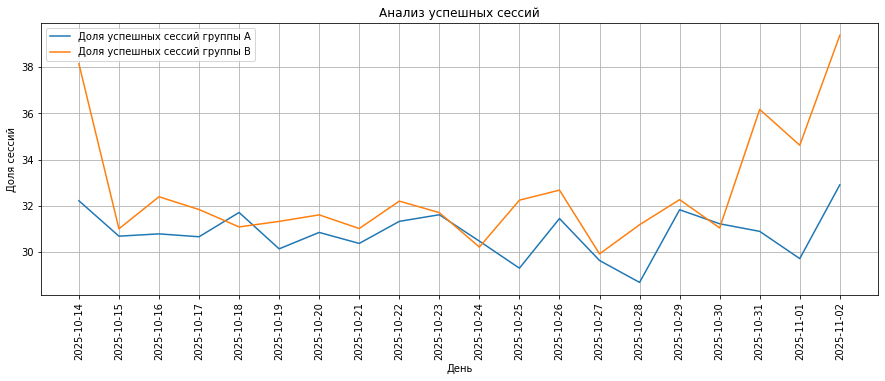

In [20]:
# находим "успешные" сессии
good_session_a = group_a[group_a['good_session'] == 1]
good_session_a = good_session_a.groupby('session_date')['session_id'].count()

good_session_b = group_b[group_b['good_session'] == 1]
good_session_b = good_session_b.groupby('session_date')['session_id'].count()

# находим долю "успешных" сессий от общего числа
share_good_session_a = good_session_a / count_session_a * 100
share_good_session_b = good_session_b / count_session_b * 100

plt.figure(figsize=(15, 5))

# строим график
plt.plot(share_good_session_a, label='Доля успешных сессий группы А')
plt.plot(share_good_session_b, label='Доля успешных сессий группы В')

# оформление графика
plt.title('Анализ успешных сессий')
plt.xlabel('День')     
plt.ylabel('Доля сессий')
plt.legend() 
plt.xticks(rotation=90)
plt.grid(True) 

# Отображение графика
plt.show()

In [21]:
good_session_a = group_a[group_a['good_session'] == 1]
good_session_b = group_b[group_b['good_session'] == 1]


count_good_session_a = len(good_session_a)
count_good_session_b = len(good_session_b)
count_all_session_a = len(group_a)
count_all_session_b = len(group_b)

share_good_session_a_value = count_good_session_a / count_all_session_a * 100
share_good_session_b_value = count_good_session_b / count_all_session_b * 100

print(f'Кол-во успешных сессий в группе В на {round(share_good_session_b_value - share_good_session_a_value, 1)}% выше, чем в группе А')

Кол-во успешных сессий в группе В на 1.1% выше, чем в группе А


#### 4.4. Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге мы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.

- Используя статистический тест, рассчитаем, является ли изменение в метрике доли успешных сессий статистически значимым.

In [22]:
n_a, n_b = count_all_session_a, count_all_session_b ## размеры выборок A и B
m_a, m_b = count_good_session_a, count_good_session_b # количество успехов в группе A и в группе B

p_a, p_b = m_a/n_a, m_b/n_b # рассчитываем доли успехов для каждой группы: A и B

print(f'n_a={n_a}, n_b={n_b}')

print(f'm_a={m_a}, m_b={m_b}')

print(f'p_a={p_a}, p_b={p_b}')

if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10):
    print('Изменение в метрике доли успешных сессий является статистически значимым!')
else:
    print('Изменение в метрике доли успешных сессий не является статистически значимым!')

n_a=49551, n_b=50454
m_a=15248, m_b=16059
p_a=0.3077233557344958, p_b=0.31828992745867524
Изменение в метрике доли успешных сессий является статистически значимым!


In [23]:
alpha = 0.05 ## на каком уровне значимости проверяем гипотезу о равенстве вероятностей

stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='smaller' # так как H_1: p_a < p_b
)
p_value_ztest
# 1.3630147762819648e-10

if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')

pvalue=0.0001574739988036123 < 0.05
Нулевая гипотеза не находит подтверждения!


#### 4.5. Вывод по результатам A/B-эксперимента

На основе проведённого анализа результатов теста сформулируйте и запишите свои выводы для команды разработки приложения. В выводе обязательно укажите:

- Характеристики проведённого эксперимента, количество задействованных пользователей и длительность эксперимента.

- Повлияло ли внедрение нового алгоритма рекомендаций на рост ключевой метрики и как.

- Каким получилось значение p-value для оценки статистической значимости выявленного эффекта.

- Стоит ли внедрять нововведение в приложение.

Мы провели A/B-тест и брали за основу следующую нулевую и альтернативную гипотезы 
- H0: кол-во "успешных" сессий при добавлении нового алгоритма рекомендательных систем не изменится
- H1: Кол-во "успешных" сессий при добавлении нового алгоритма рекомендательных систем увеличится

В качестве целевой метрики брали количество "успешных" сессий, то есть количество сессий, где пользователь посетил четыре и более страницы за одну сессию.

Рассчитали, что для проведения эксперимента необходимый размер выборки для каждой группы составляет 41 040 пользователей и эксперимент должен проходить 9 дней при текущем уровене трафика в 9 907 пользователей в день. 

Внедрение нового алгоритма рекомендаций повлияло на рост ключевой метрики: количество "успешных" сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной. 

Несмотря на, казалось бы, незначительное изменение, значение p-value составило 0.0001574739988036123, что позволяет нам отвергнуть нулевую гипотезу. 

Из этого мы можем сделать вывод, что целесообразно будет внедрить новую систему рекомендаций в приложение!